original_dag has 1 connected components


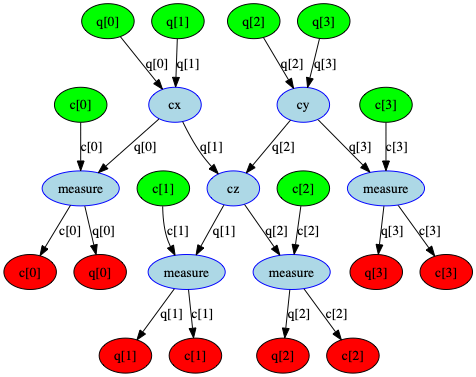

In [42]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import *
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
from qiskit.extensions.standard import CHGate, HGate, CnotGate, CyGate, CzGate
from qiskit.circuit import Measure
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
from qiskit import *
import numpy as np
import itertools
import networkx as nx
import pickle
import copy

q = QuantumRegister(4, 'q')
c = ClassicalRegister(4, 'c')
circ = QuantumCircuit(q,c)
# circ.h([q[2],q[1]])
# circ.x([q[2],q[0]])
# circ.y(q[3])
circ.cx(q[0], q[1])
circ.cy(q[2], q[3])
circ.cz(q[1], q[2])
# circ.x(q[2])
# circ.barrier()
circ.measure(q,c)
circ.draw()

dag = circuit_to_dag(circ)
print('original_dag has %d connected components' % nx.number_weakly_connected_components(dag._multi_graph))
# print(nx.algorithms.connectivity.cuts.minimum_edge_cut(dag._multi_graph))
original_dag = copy.deepcopy(dag)
dag_drawer(original_dag)

cut_dag has 2 connected components


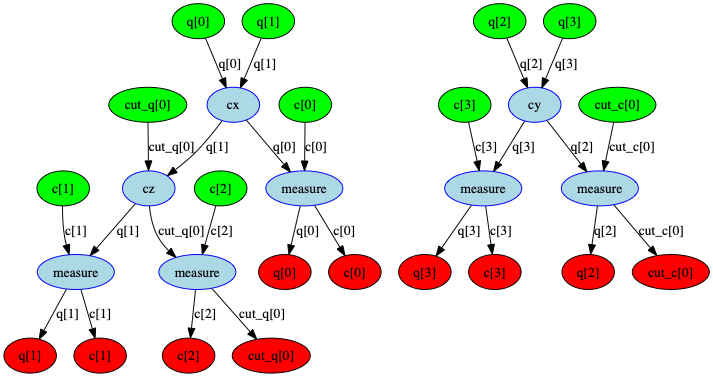

In [43]:
# cut an edge
for node in dag.op_nodes():
    if node.name == 'cy':
        source_node = node
    if node.name == 'cz':
        dest_node = node
dag.insert_measure(op=Measure(),qarg=q[2],source_node=source_node, dest_node=dest_node)
print('cut_dag has %d connected components' % nx.number_weakly_connected_components(dag._multi_graph))
cut_dag = copy.deepcopy(dag)
dag_drawer(cut_dag)

In [44]:
dag_to_circuit(cut_dag).draw()

In [45]:
num_components = nx.number_weakly_connected_components(cut_dag._multi_graph)
sub_dags = []
for i in range(num_components):
    sub_dag = copy.deepcopy(cut_dag)
    nodes_to_retain = list(nx.weakly_connected_components(sub_dag._multi_graph))[i]
    all_nodes = list(sub_dag.nodes())
    for node in all_nodes:
        if node not in nodes_to_retain:
            sub_dag._multi_graph.remove_node(node)
    sub_dags.append(sub_dag)

pickle.dump([original_dag, cut_dag, sub_dags], open("cuts.p", "wb"))

In [46]:
[original_dag, cut_dag, sub_dags] = pickle.load(open( "cuts.p", "rb" ))
dag_drawer(original_dag, filename='original_dag.pdf')
dag_drawer(cut_dag, filename='cut_dag.pdf')
dag_drawer(sub_dags[0], filename='sub_dags_0.pdf')
dag_drawer(sub_dags[1], filename='sub_dags_1.pdf')

qc = dag_to_circuit(sub_dags[1])

qc.draw(filename='sub_circ_0.txt')

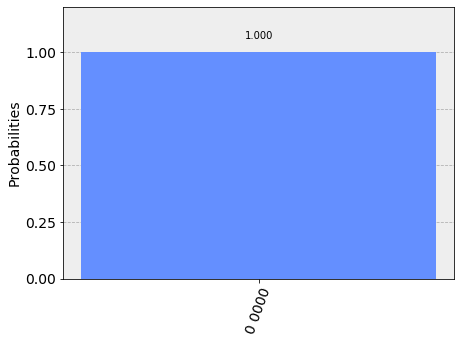

In [47]:
backend_sim = BasicAer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)
plot_histogram(counts)